In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np 
device = tf.device("gpu:0")
# Step 1: Dataset Preparation
# Set the paths to your dataset
train_data_dir =   './Train/'
test_data_dir =   'Val/'


In [2]:

# Step 2: Data Preprocessing
image_size = (224, 224)  # Adjust the size as per your requirements

# Data augmentation for training set (optional)

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=10,  # Example of augmentation parameters
    zoom_range=0.1,
    horizontal_flip=True
)


# Data normalization for testing set
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical'
)


Found 5269 images belonging to 3 classes.
Found 1461 images belonging to 3 classes.


In [3]:
# Step 5: Check the class labels
class_labels = list(train_generator.class_indices.keys())
num_classes = len(class_labels)

# Step 6: Check the class imbalance
class_counts = np.sum(train_generator.labels, axis=0)

# Step 7: Print dataset statistics
print("Number of classes:", num_classes)
print("Class labels:", class_labels)
print("Class counts:", class_counts)




Number of classes: 3
Class labels: ['Strawberry___Leaf_scorch', 'Strawberry___healthy', 'nonValid']
Class counts: 5166


In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import Dropout
l1_weight = 0.001  # L1 regularization weight
l2_weight = 0.001  # L2 regularization weight
dropout_rate = 0.5  # Dropout rate


# Step 3: Model Creation and Fine-tuning
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224,224, 3))


In [5]:

for layer in base_model.layers:  # Fine-tune the last n layers
    layer.trainable = False

x = base_model.output

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Add more convolutional layers if desired
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1_weight, l2_weight))(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)

x = Dropout(dropout_rate)(x)  # Adding a Dropout layer with the specified dropout rate
predictions = layers.Dense(3, activation='softmax')(x)



In [6]:
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
# ...
# After creating the final model

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)
checkpoint = ModelCheckpoint('STRAWBERRY_BEST_MODEL.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)


In [4]:
with tf.device("/GPU:0"):
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        steps_per_epoch=train_generator.n // train_generator.batch_size,
        validation_steps=validation_generator.n // validation_generator.batch_size,
        epochs=10,
        callbacks=[reduce_lr, checkpoint, early_stop]
    )



Epoch 1/10
164/164 [==============================] - 518s 3s/step - loss: 1.7516 - accuracy: 0.7632 - val_loss: 0.7465 - val_accuracy: 0.9639

Epoch 00001: val_accuracy improved from -inf to 0.96389, saving model to STRAWBERRYBESTMODEL.h5
Epoch 2/10
164/164 [==============================] - 1312s 8s/step - loss: 0.5855 - accuracy: 0.9544 - val_loss: 0.4664 - val_accuracy: 0.9403

Epoch 00002: val_accuracy did not improve from 0.96389
Epoch 3/10
164/164 [==============================] - 1212s 7s/step - loss: 0.2802 - accuracy: 0.9765 - val_loss: 0.1859 - val_accuracy: 0.9819

Epoch 00003: val_accuracy improved from 0.96389 to 0.98194, saving model to STRAWBERRYBESTMODEL.h5
Epoch 4/10
164/164 [==============================] - 1373s 8s/step - loss: 0.1753 - accuracy: 0.9803 - val_loss: 0.1410 - val_accuracy: 0.9778

Epoch 00004: val_accuracy did not improve from 0.98194
Epoch 5/10
164/164 [==============================] - 1430s 9s/step - loss: 0.1395 - accuracy: 0.9784 - val_loss: 0.

In [5]:

# Step 5: Model Evaluation
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation loss: {loss}")
print(f"Validation accuracy: {accuracy}")

46/46 [==============================] - 61s 1s/step - loss: 0.0711 - accuracy: 0.9897
Validation loss: 0.07106591016054153
Validation accuracy: 0.9897330403327942


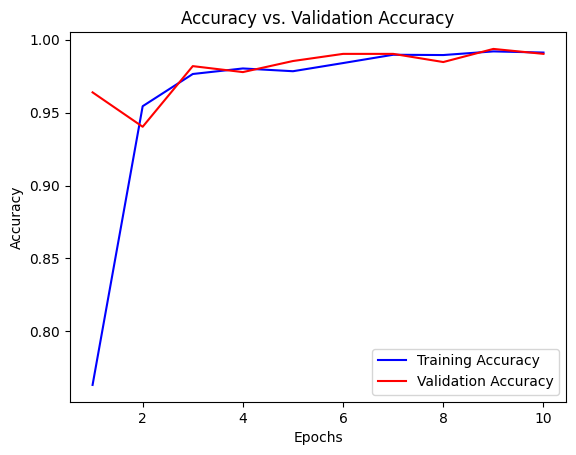

In [30]:
import matplotlib.pyplot as plt

accuracy=[0.7632, 0.9544, 0.9765, 0.9803, 0.9784, 0.9840, 0.9897, 0.9895, 0.9920, 0.9912 ]
val_accuracy=[0.9639,0.9403,0.9819,0.9778,0.9854,0.9903,0.9903,0.9847,0.9937,0.9903]

# Plotting the graph
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Accuracy vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

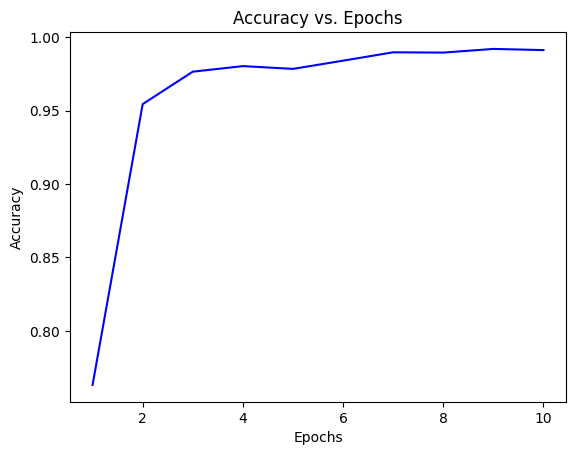

In [31]:
import matplotlib.pyplot as plt

# Example data
accuracy=[0.7632, 0.9544, 0.9765, 0.9803, 0.9784, 0.9840, 0.9897, 0.9895, 0.9920, 0.9912 ]
epochs = range(1, len(accuracy) + 1)

# Plotting the graph
plt.plot(epochs, accuracy, 'b')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


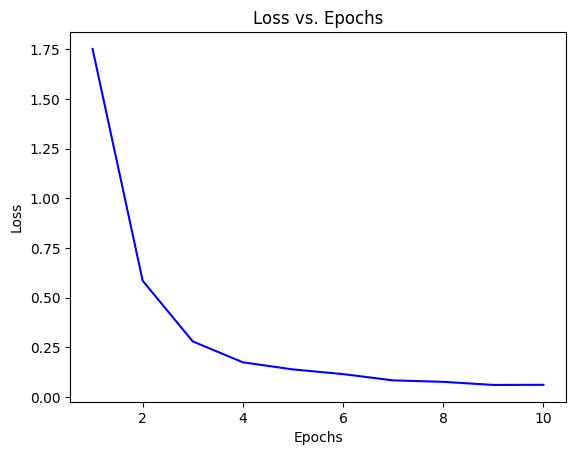

In [35]:
loss=[1.7516,0.5855,0.2802,0.1753,0.1395,0.1159,0.0844,0.0770,0.0615,0.0620]
val_loss=[0.7465,0.4664,0.1859,0.1410,0.1095,0.0712,0.0640,0.0766,0.0495,0.0687]

# Plotting the graph
plt.plot(epochs, loss, 'b')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

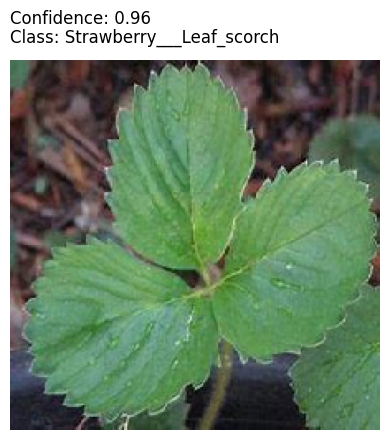

In [15]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import load_model


# Load and preprocess the image
img_path = "PathImage"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Normalize the image pixel values
input_img = np.expand_dims(img_array, axis=0)

# Perform predictions on the image
predictions = model.predict(input_img)
class_names = list(train_generator.class_indices.keys())

# Get the index and confidence of the maximum confidence prediction
max_index = np.argmax(predictions[0])
max_confidence = predictions[0][max_index]
max_class_name = class_names[max_index]

# Plot the image
fig, ax = plt.subplots()
ax.imshow(img)
ax.axis('off')

# Print the class and confidence below the image
ax.text(0, 1.05, f"Class: {max_class_name}", transform=ax.transAxes, fontsize=12)
ax.text(0, 1.1, f"Confidence: {max_confidence:.2f}", transform=ax.transAxes, fontsize=12)

plt.show()
